### Data augmentation of character images for training of classification model

In [166]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import random

from matplotlib import pyplot as plt
import seaborn as sns

import imgaug as ia
import imgaug.augmenters as iaa
from skimage.transform import swirl

from PIL import Image

from pathlib import Path

import inspect as i

In [167]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
INPUT_FOLDER = r'/home/hkolstee/uniprojects/DATA/HWR/monkbrill'
OUTPUT_FOLDER = INPUT_FOLDER + "_augm"

In [168]:
# create output folder
if os.path.isdir(INPUT_FOLDER):
    if not os.path.isdir(OUTPUT_FOLDER):
        os.mkdir(OUTPUT_FOLDER)

## Data preparation

In [169]:
def create_dataset(img_folder):
   
    img_data_array = []
    class_names = []
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path = os.path.join(img_folder, dir1,  file)
            image = cv2.imread(image_path, -1)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            # if image is not grayscale
            if (image.shape != (28, 28)):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # invert
            image = cv2.bitwise_not(image)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_names.append(dir1)
            
    return img_data_array, class_names

In [170]:
# image array and class name
img_data, class_names = create_dataset(INPUT_FOLDER)

x = np.array(img_data, dtype = np.float32)

## Data observation

In [171]:
classes, counts = np.unique(class_names, return_counts = True)

data_dict = {}
for (key, value) in zip(classes, counts):
    data_dict[key] = value
    
# print(f"Unique classes and number of images:")
# data_dict

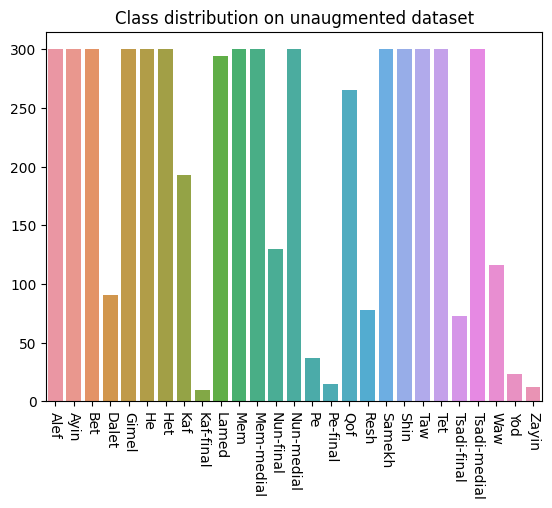

In [172]:
df = pd.DataFrame(data_dict, index=[0])
fig = sns.barplot(df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=-90, horizontalalignment='center')
fig.set(title="Class distribution on unaugmented dataset")
plt.show()

### Example images

In [173]:
def display_images(image_list, title):
    nr_images = len(image_list)
    
    # size of x axis in grid
    x = int(np.floor(np.sqrt(nr_images)))
    # size of y axis in grid
    y = int(np.ceil(nr_images/x))
    
    fig, axs = plt.subplots(x, y)
    axs = axs.flatten()
    for (image, ax) in zip(image_list, axs):
        ax.imshow(image, cmap = "Greys")
    
    fig.suptitle(title)
    plt.show()

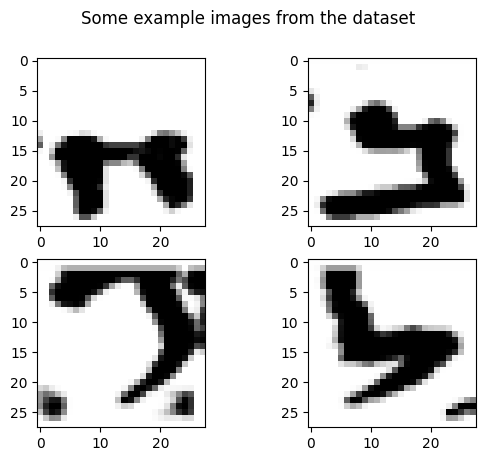

In [174]:
images = []
for image_class in classes[6:10]:
    images.append(img_data[class_names.index(image_class)])
display_images(images, "Some example images from the dataset")    

## Split into train / test

In [ ]:
# take first element of each class

# 20% of indices in set
test_indices = np.random.randint(0, len(class_names), len(class_names) // 5)

test_x = [img_data[idx] for idx in test_indices]
test_y = [class_names[idx] for idx in test_indices]

train_x = np.delete(img_data, test_indices)
train_y = np.delete(class_names, test_indices)

## Data augmentation   
We will be using the package **imgaug**.   
Data is still ***img_data*** and ***class_name***.

### Augmentations:
- Rotate
- Scale
- Gaussian noise
- Shear (X/Y)
- Translate (X/Y)
- Swirl
- Elastic transform
- Random erase


In [175]:
def rotate_image(input_img, rotation):
    rot = iaa.Affine(rotate = rotation)
    rotated_img = rot.augment_image(input_img)
    return rotated_img

def scale_image(input_img, percent):
    scale = iaa.Affine(scale = percent)
    scaled_img = scale.augment_image(input_img)
    return scaled_img

def gaussian_noise(input_img, std_of_normal):
    noise = iaa.AdditiveGaussianNoise(scale = std_of_normal)
    noisy_img = noise.augment_image(input_img)
    return noisy_img

def shearX_image(input_img, degree):
    shear = iaa.ShearX(shear = degree)
    sheared_img = shear.augment_image(input_img)
    return sheared_img

def shearY_image(input_img, degree):
    shear = iaa.ShearY(shear = degree)
    sheared_img = shear.augment_image(input_img)
    return sheared_img

def translateX(input_img, percent):
    tX = iaa.TranslateX(percent = percent)
    tX_img = tX.augment_image(input_img)
    return tX_img

def translateY(input_img, percent):
    tY = iaa.TranslateY(percent = percent)
    tY_img = tY.augment_image(input_img)
    return tY_img

def swirl_image(input_img, rotation, strength, radius):
    swirled_img = swirl(input_img, rotation = rotation, strength = strength, radius = radius)
    return swirled_img

def elastic_transform(input_img, alpha, sigma):
    elastic = iaa.ElasticTransformation(alpha = alpha, sigma = sigma)
    elastic_img = elastic.augment_image(input_img)
    return elastic_img

# randomly erases a block of about 10% of the image
def random_erase(input_img):
    # create output img
    output_img = np.copy(input_img)
    
    for i in range(2):
        # get x and y coords
        randomX1 = random.uniform(0., 0.7)
        randomX2 = random.uniform(randomX1+0.075, 1.0)
        randomY1 = random.uniform(0., 0.7)
        randomY2 = (0.075 / (abs(randomX1 - randomX2))) + randomY1

        # loop over pixels to erase
        for i in range(round(randomX1*27), round(randomX2*27)):
            for j in range(round(randomY1*27), min(round(randomY2*27), 28)):
                output_img[i][j] = 0.
    
    return output_img

In [176]:
def random_augment(input_img, nr_of_augments):
    # list of functions
    functions = [lambda x : rotate_image(x, -15), lambda x : rotate_image(x, 15), lambda x : scale_image(x, 0.8), lambda x : scale_image(x, 1.2), 
                lambda x : gaussian_noise(x, 0.075), lambda x : shearX_image(x, 30), lambda x : shearX_image(x, -30), 
                lambda x : shearY_image(x, 30), lambda x : shearY_image(x, -30), lambda x : translateX(x, 0.1), 
                lambda x : translateX(x, -0.1), lambda x : translateY(x, 0.1), lambda x : translateY(x, -0.1), 
                lambda x : swirl_image(x, rotation = -0.15, strength = -1, radius = 30), 
                lambda x : swirl_image(x, rotation = 0.15, strength = 1, radius = 30), lambda x : random_erase(x),
                lambda x : elastic_transform(x, 50, 8)]
    
    # copy input img
    output_img = np.copy(input_img)
    # apply augments
    for i in range(nr_of_augments):
        output_img = random.choice(functions)(output_img)
        
    return output_img    

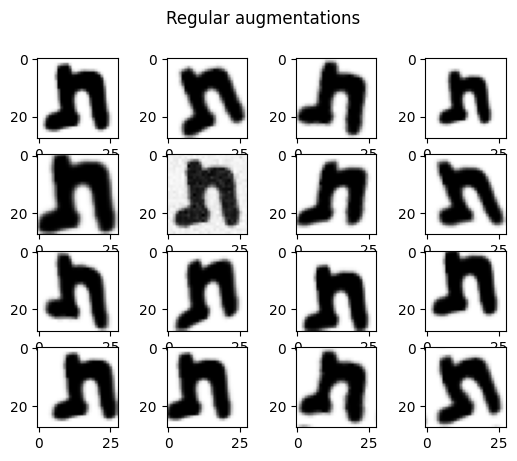

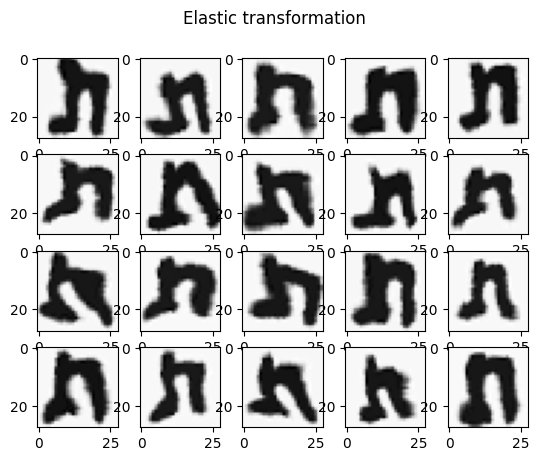

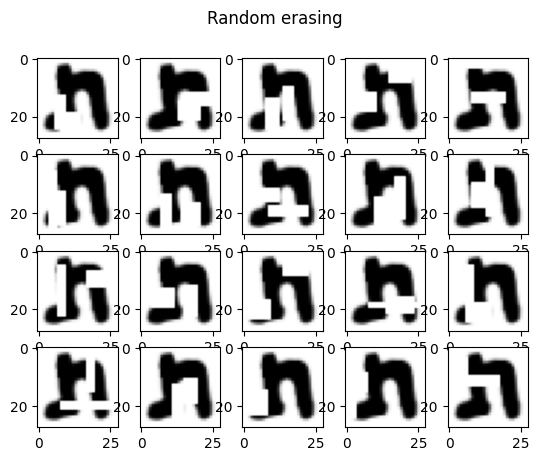

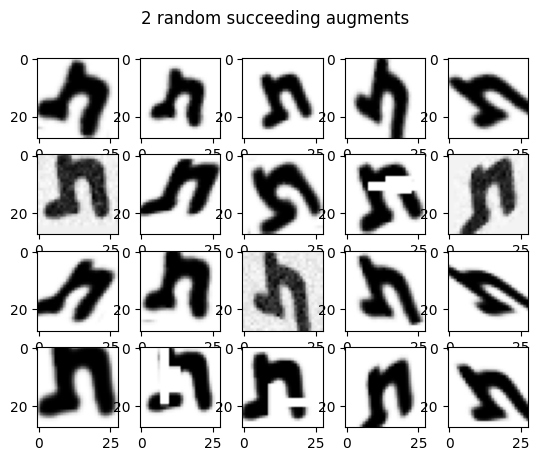

In [177]:
regular_augment_imgs = []
elastic_imgs = []
random_erase_imgs = []
random_augments_imgs = []
# we will be using image 1000 to showcase the augmentations
input_img = img_data[2005]

# augmentations
rotated_img1 = rotate_image(input_img, -15)
rotated_img2 = rotate_image(input_img, 15)
scaled_img1 = scale_image(input_img, 0.8)
scaled_img2 = scale_image(input_img, 1.2)
gaussian_noise_img = gaussian_noise(input_img, 0.05)
shearedX_img1 = shearX_image(input_img, 15)
shearedX_img2 = shearX_image(input_img, -15)
shearedY_img1 = shearY_image(input_img, 15)
shearedY_img2 = shearY_image(input_img, -15)
translateX_img1 = translateX(input_img, 0.1)
translateX_img2 = translateX(input_img, -0.1)
translateY_img1 = translateY(input_img, 0.1)
translateY_img2 = translateY(input_img, -0.1)
swirled_image1 = swirl_image(input_img, rotation = -0.15, strength = -1, radius = 30)
swirled_image2 = swirl_image(input_img, rotation = 0.15, strength = 1, radius = 30)

# append and display
regular_augment_imgs.append(input_img)
regular_augment_imgs.append(rotated_img1)
regular_augment_imgs.append(rotated_img2)
regular_augment_imgs.append(scaled_img1)
regular_augment_imgs.append(scaled_img2)
regular_augment_imgs.append(gaussian_noise_img)
regular_augment_imgs.append(shearedX_img1)
regular_augment_imgs.append(shearedX_img2)
regular_augment_imgs.append(shearedY_img1)
regular_augment_imgs.append(shearedY_img2)
regular_augment_imgs.append(translateY_img1)
regular_augment_imgs.append(translateY_img2)
regular_augment_imgs.append(translateX_img1)
regular_augment_imgs.append(translateX_img2)
regular_augment_imgs.append(swirled_image1)
regular_augment_imgs.append(swirled_image2)
display_images(regular_augment_imgs, "Regular augmentations")

# showcase elastic transformation
for i in range(20):
    image = elastic_transform(input_img, 50, 8)
    elastic_imgs.append(image)
display_images(elastic_imgs, "Elastic transformation")

# showcase random erase
for i in range(20):
    image = random_erase(input_img)
    random_erase_imgs.append(image)
display_images(random_erase_imgs, "Random erasing")

# showcase 3 random augments in succession
for i in range(20):
    image = random_augment(input_img, 2)
    random_augments_imgs.append(image)
display_images(random_augments_imgs, "2 random succeeding augments")

## Transform the dataset

### Check inbalance

In [178]:
classes, counts = np.unique(train_y, return_counts = True)

data_dict = {}
for (key, value) in zip(classes, counts):
    data_dict[key] = value
    
print(f"Unique classes and number of images:")
data_dict

Unique classes and number of images:


{'Alef': 300,
 'Ayin': 300,
 'Bet': 300,
 'Dalet': 91,
 'Gimel': 300,
 'He': 300,
 'Het': 300,
 'Kaf': 193,
 'Kaf-final': 10,
 'Lamed': 294,
 'Mem': 300,
 'Mem-medial': 300,
 'Nun-final': 130,
 'Nun-medial': 300,
 'Pe': 37,
 'Pe-final': 15,
 'Qof': 265,
 'Resh': 78,
 'Samekh': 300,
 'Shin': 300,
 'Taw': 300,
 'Tet': 300,
 'Tsadi-final': 73,
 'Tsadi-medial': 300,
 'Waw': 116,
 'Yod': 23,
 'Zayin': 12}

### Add all images to new augmented directory

In [179]:
# image array and class name
# img_data, class_names = create_dataset(INPUT_FOLDER)

In [180]:
for idx, (img, class_name) in enumerate(zip(train_x, train_y)):
    # check if folder exists
    if not os.path.isdir(OUTPUT_FOLDER + "/" + class_name):
            # create folder
            os.mkdir(OUTPUT_FOLDER + "/" + class_name)
            
    # add all original images to augmented directories
    # invert
    img = 1 - img
    img *= 255
    img = img.astype("int32")
    image = Image.fromarray(img)
    image = image.convert("L")
    image.save(os.path.join(OUTPUT_FOLDER, class_name, class_name + str(idx) + ".jpg"))

### Use ***elastic transform*** to add to inbalanced classes till 300 images

In [181]:
for class_dir in os.listdir(OUTPUT_FOLDER):
    # print(class_dir)
    # determine how many images per class directory
    nr_of_files = len([name for name in os.listdir(os.path.join(OUTPUT_FOLDER, class_dir)) if os.path.isfile(os.path.join(OUTPUT_FOLDER, class_dir, name))])
    # print(nr_of_files)
    
    # fill to 300 with elastic transforms
    if (nr_of_files < 300):
        img_buffer = []
        # print(300 - nr_of_files)
        
        # add untill 300
        for i in range(300 - nr_of_files):
            # print(class_dir, i)
            # select random file out of 300
            image_path = random.choice(os.listdir(OUTPUT_FOLDER + "/" + class_dir))
            image = cv2.imread(os.path.join(OUTPUT_FOLDER, class_dir, image_path), -1)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            # # if image is not grayscale
            if (image.shape != (28, 28)):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # invert
            image = cv2.bitwise_not(image)
            image = np.array(image)
            
            # transform img
            transformed_img = elastic_transform(image, 50, 8)
            # invert after transform to prevent black border due to transform
            transformed_img = cv2.bitwise_not(transformed_img)
            
            # save transformed img
            transformed_img = Image.fromarray(transformed_img)
            # add img and file_name to buffer to not sample from transformed imgs
            img_buffer.append((transformed_img, os.path.join(OUTPUT_FOLDER, class_dir, Path(image_path).stem + str(i) + ".jpg")))
        
        # add all transformed images in buffer to directory
        # print(img_buffer)
        for img, file_name in img_buffer:
            # print(img.shape, file_name)
            img.save(file_name)

### Check balance

In [182]:
# image array and class name
img_data, class_names = create_dataset(OUTPUT_FOLDER)
# get number of uniques
classes, counts = np.unique(class_names, return_counts = True)

data_dict = {}
for (key, value) in zip(classes, counts):
    data_dict[key] = value

print(f"Unique classes and number of images:")
data_dict

Unique classes and number of images:


{'Alef': 300,
 'Ayin': 300,
 'Bet': 300,
 'Dalet': 300,
 'Gimel': 300,
 'He': 300,
 'Het': 300,
 'Kaf': 300,
 'Kaf-final': 300,
 'Lamed': 300,
 'Mem': 300,
 'Mem-medial': 300,
 'Nun-final': 300,
 'Nun-medial': 300,
 'Pe': 300,
 'Pe-final': 300,
 'Qof': 300,
 'Resh': 300,
 'Samekh': 300,
 'Shin': 300,
 'Taw': 300,
 'Tet': 300,
 'Tsadi-final': 300,
 'Tsadi-medial': 300,
 'Waw': 300,
 'Yod': 300,
 'Zayin': 300}

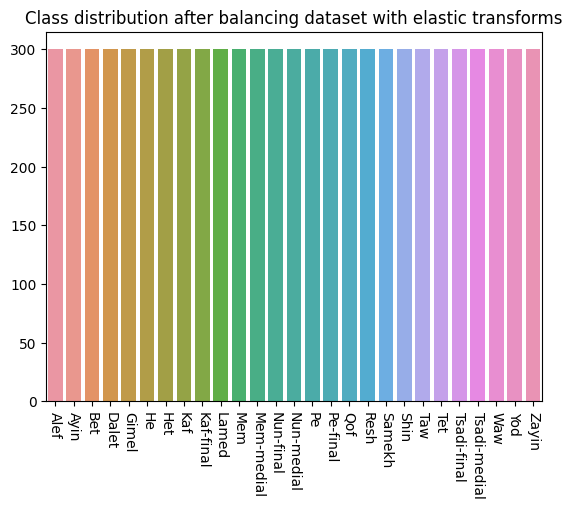

In [183]:
df = pd.DataFrame(data_dict, index=[0])
fig = sns.barplot(df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=-90, horizontalalignment='center')
fig.set(title="Class distribution after balancing dataset with elastic transforms")
plt.show()

# Add augmentations to new dataset
images = img_data, labels = class_names

In [184]:
print(len(img_data), len(class_names))

8100 8100


### We add the following transforms to each image: 
- random erasing
- 